In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS
using Plots; gr();

  Activating environment at `~/Coding/julia/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [8]:
dd = IMAS.json2imas("/Users/meneghini/.julia/dev/FUSE/sample/CAT_eq_ods.json");
IMAS.flux_surfaces(dd.equilibrium);

In [2]:
ϵ = 0.32
κ = 1.7
δ = 0.3
R0 = 6.2
B0 = 5.3
ip = 15.E6
beta_n = 3.0
x_point=true
symmetric=true

resolution = 129

dd = IMAS.dd()
resize!(dd.equilibrium.time_slice,1)
FUSE.init(dd.equilibrium.time_slice[1]; B0, R0, ϵ, δ, κ, beta_n, ip, x_point=x_point)

eqactor = FUSE.SolovevEquilibriumActor(dd.equilibrium.time_slice[1], symmetric=symmetric)
@time FUSE.step(eqactor)
dd.equilibrium.time_slice[1] = FUSE.finalize(eqactor, resolution, (maximum([R0*(1-ϵ*2),0.0]), R0*(1+ϵ*2)), (-R0*ϵ*κ*2, R0*ϵ*κ*2));
dd.equilibrium.time=[0.0]
dd.equilibrium.vacuum_toroidal_field.r0=R0
dd.equilibrium.vacuum_toroidal_field.b0=[B0]

plot(dd.equilibrium.time_slice[1]);

 27.228948 seconds (103.01 M allocations: 5.601 GiB, 5.82% gc time, 98.66% compilation time)


  0.022467 seconds (30.07 k allocations: 2.872 MiB)


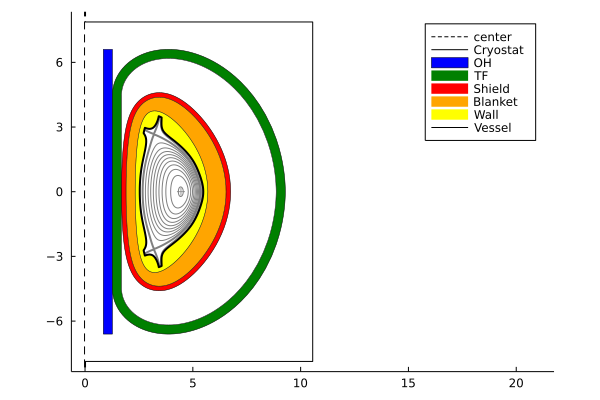

In [10]:
# initialize and run radial build actor
rb=IMAS.radial_build()
eqt=dd.equilibrium.time_slice[1]
@time rbactor = FUSE.init(rb, eqt, is_nuclear_facility=true, conformal_wall=true);
FUSE.step(rbactor)
dd.radial_build = FUSE.finalize(rbactor)

plot(eqt,color=:gray)
plot!(rb,outline=true)
#display(plot!(rb,outline=false))

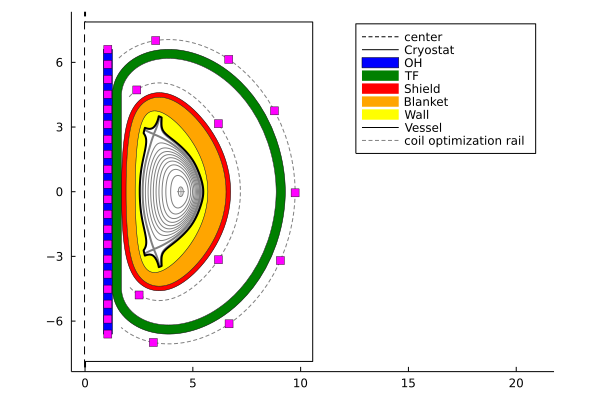

In [11]:
# initialize pf actor
pfoptactor = PFcoilsOptActor(dd.equilibrium,dd.radial_build, 20, [[0.03,0.3,1-0.3,1-0.03],7], 1E-13);

plot(eqt,color=:gray)
plot!(rb)
#plot!(rb,outline=false)
plot!(pfoptactor,equilibrium=false)
# plot!(pfoptactor.pf_active,color=:magenta)
#plot(rb)
#display(plot!(pfoptactor))

 * Status: success

 * Candidate solution
    Final objective value:     3.658354e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   71  (vs limit 120)
    Iterations:    3304
    f(x) calls:    5541



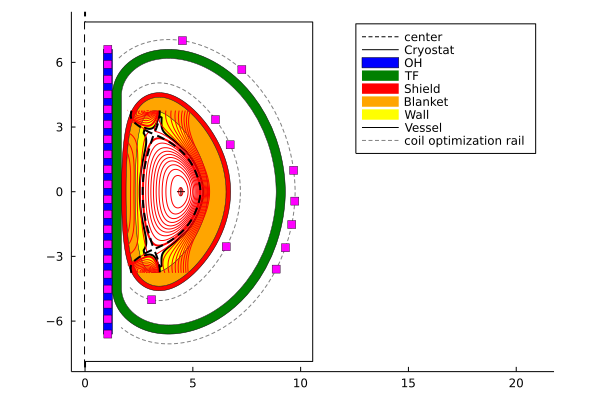

In [12]:
# run pf actor
FUSE.step(pfoptactor, λ_currents=1E5, verbose=true, symmetric=false, maxiter=10000, optimization_scheme=:rail);
plot(rb)
display(plot!(pfoptactor))

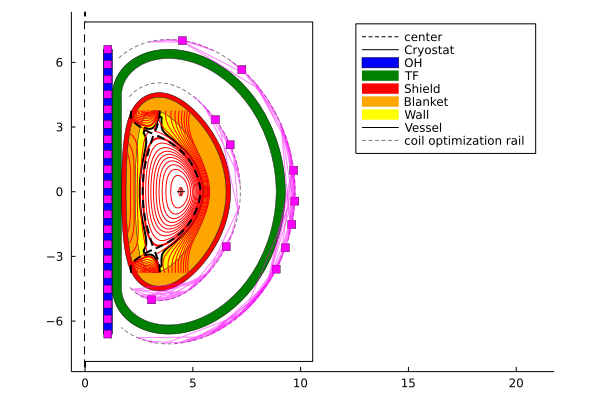

┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294
┌ Warning: No strict ticks found
└ @ PlotUtils /Users/meneghini/.julia/packages/PlotUtils/VgXdq/src/ticks.jl:294


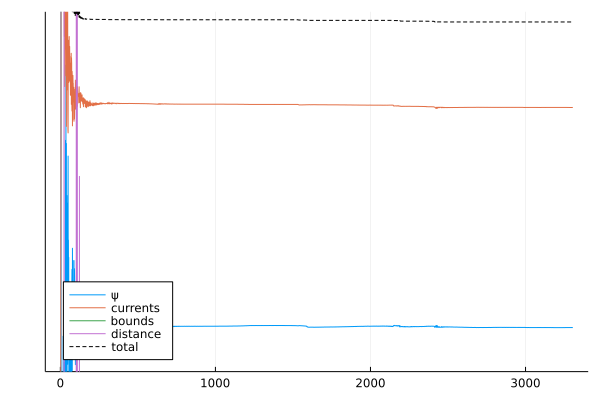

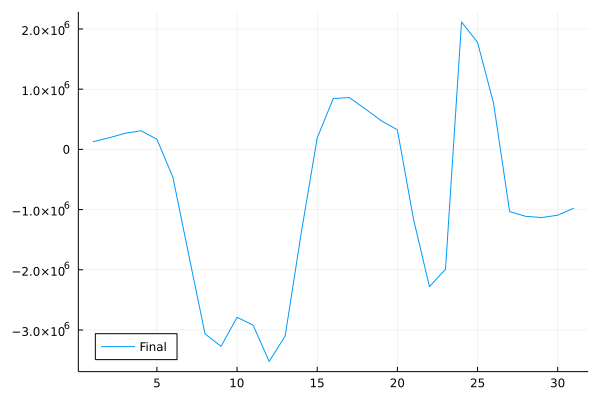

In [13]:
plot(rb)
display(plot!(pfoptactor,equilibrium=true,trace=true))

display(plot(pfoptactor.trace,:cost,start_at=2,yscale=:log10))#,xscale=:log,ylim=[:0.5,2]))
display(plot(pfoptactor.trace,:final_currents))

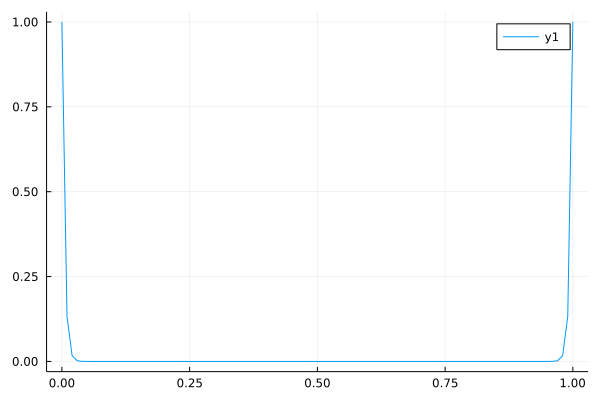

In [44]:
distances=range(0,1,length=101)
y=((distances.-0.5).*2).^100
plot(distances,y)